# Neural-Fly: Domain Adversarially Invariant Meta Learning

This script loads quadrotor flight data in different wind conditions, trains a wind invariant representation of the unmodeled aerodynamics, and tests the performance of the model when adapting to new data in different wind conditions. 

## Import libraries

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_default_tensor_type('torch.DoubleTensor')
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

import utils
import mlmodel

In [7]:
import sys
if sys.platform == 'win32':
    NUM_WORKERS = 0 # Windows does not support multiprocessing
else:
    NUM_WORKERS = 2
print('running on ' + sys.platform + ', setting ' + str(NUM_WORKERS) + ' workers')

running on win32, setting 0 workers


## Load the data and create some simple visualizations

In [8]:
dim_a = 3  # lxz:调节隐层的维度
features = ['v', 'q', 'pwm']
label = 'fa'

# Training data collected from the neural-fly drone
dataset = 'rflysim'  # 'neural-fly'
dataset_folder = 'data_my/training'
hover_pwm_ratio = 1.

# # Training data collected from an intel aero drone
# dataset = 'neural-fly-transfer'
# dataset_folder = 'data/training-transfer'
# hover_pwm = 910 # mean hover pwm for neural-fly drone
# intel_hover_pwm = 1675 # mean hover pwm for intel-aero drone
# hover_pwm_ratio = hover_pwm / intel_hover_pwm # scaling ratio from system id

modelname = f"{dataset}_dim-a-{dim_a}_{'-'.join(features)}" # 'intel-aero_fa-num-Tsp_v-q-pwm'

In [9]:
RawData = utils.load_data(dataset_folder)
Data = utils.format_data(RawData, features=features, output=label)

testdata_folder = 'data_my/experiment'
RawData = utils.load_data(testdata_folder, expnames='(baseline_)([0-9]*|no)wind')  # lxz:总共提取四次实验，不包含sin信号的变化风环境
# RawData = utils.load_data(testdata_folder, expnames='(NF_)([0-9]*|no)wind')  # lxz:总共提取四次实验，不包含sin信号的变化风环境
TestData = utils.format_data(RawData, features=features, output=label, hover_pwm_ratio=hover_pwm_ratio) # wind condition label, C, will not make sense for this data - that's okay since C is only used in the training process

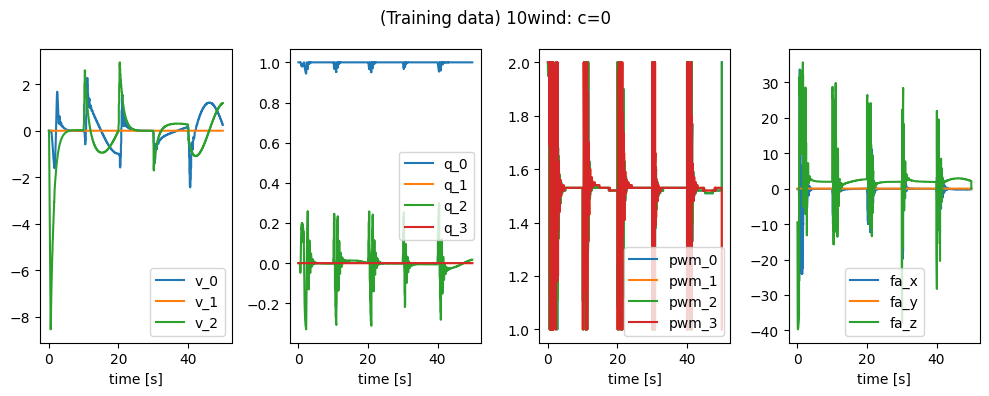

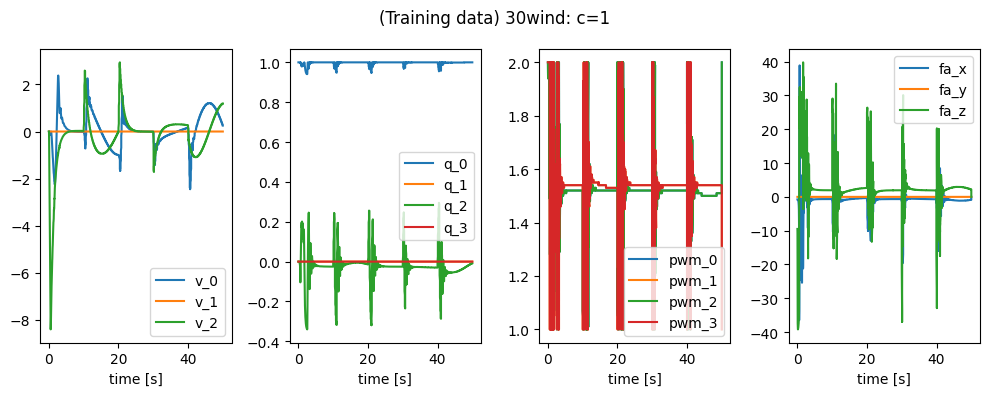

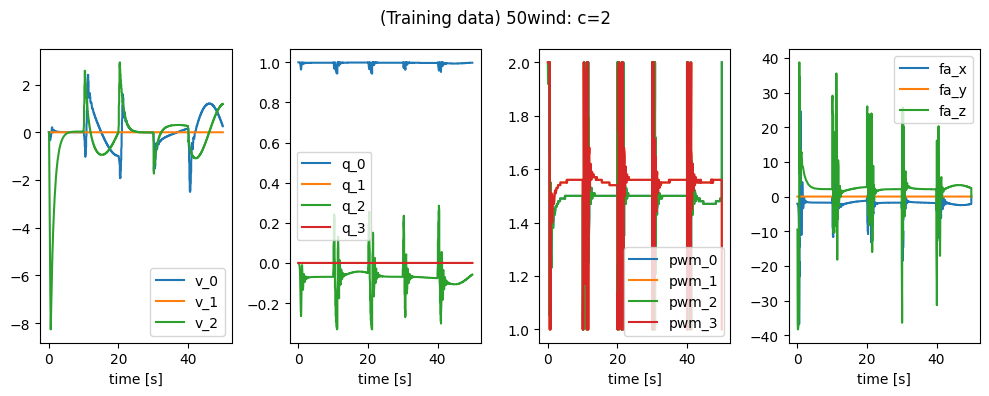

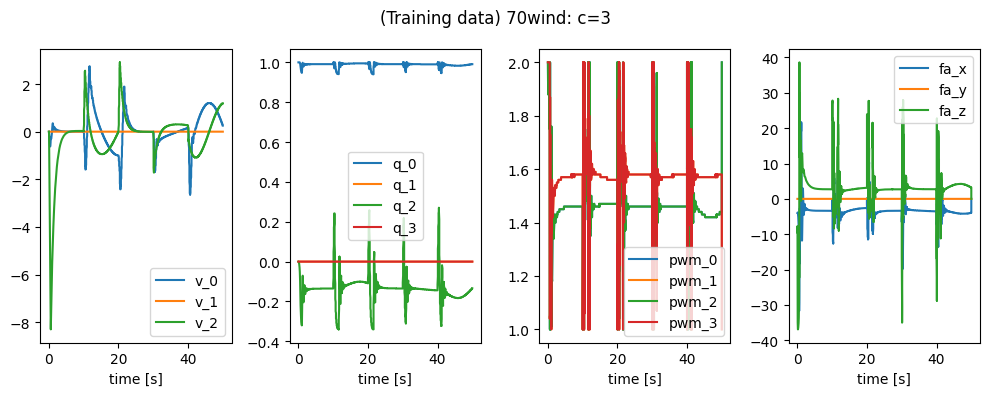

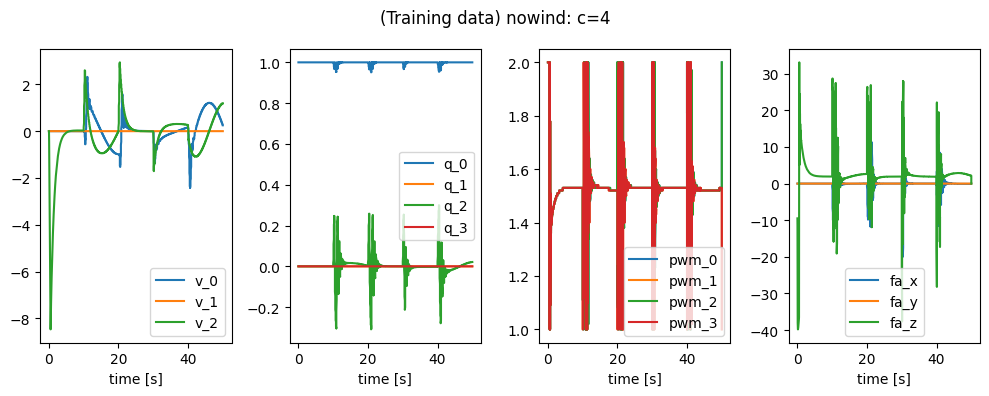

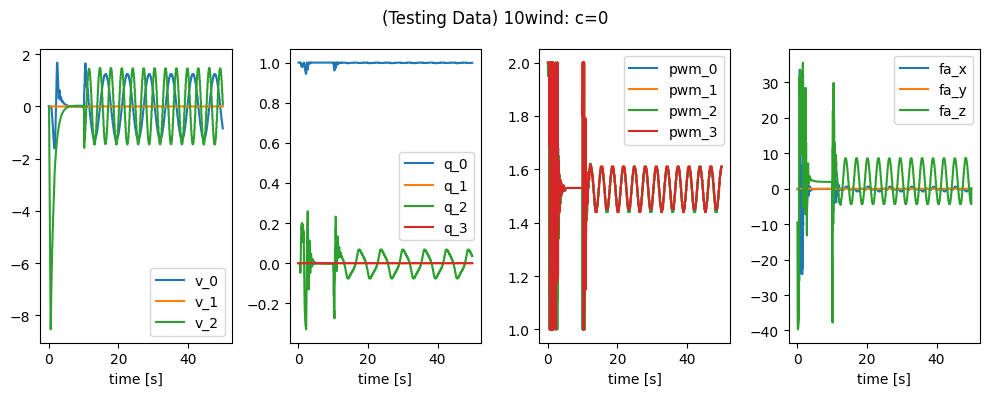

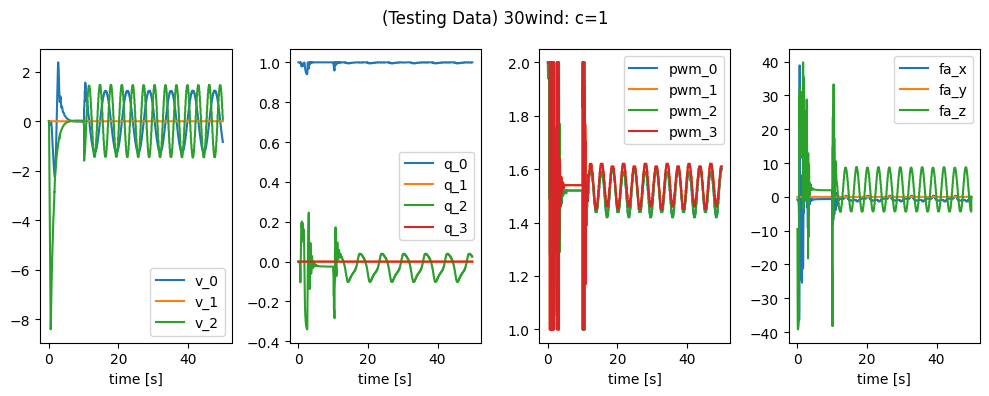

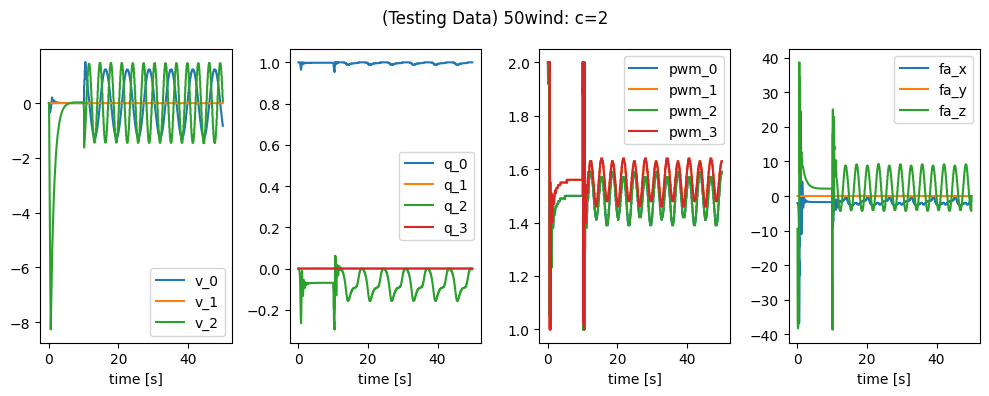

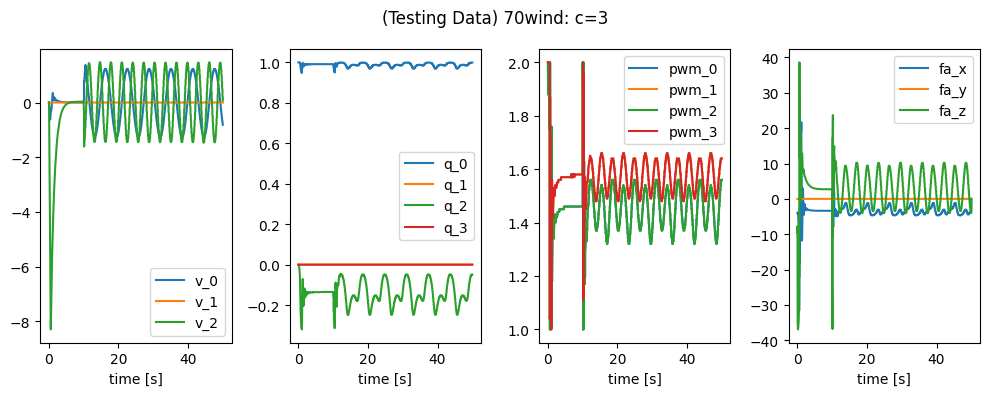

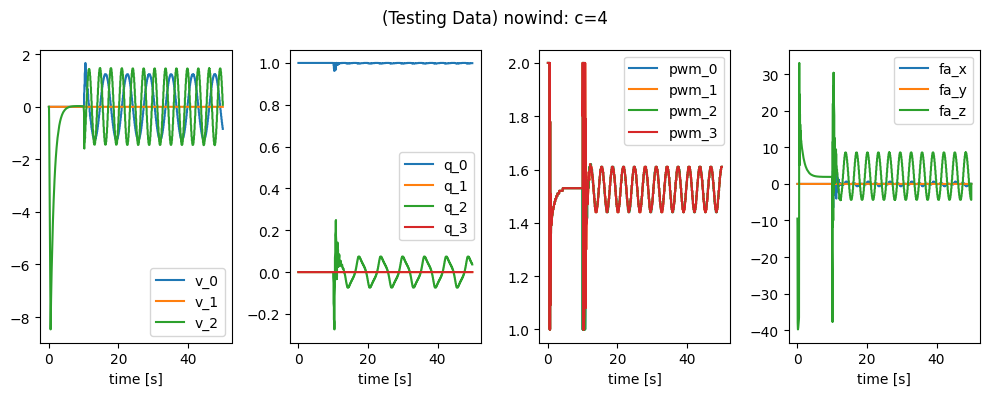

In [10]:
for data in Data:
    utils.plot_subdataset(data, features, title_prefix="(Training data)")

for data in TestData:
    utils.plot_subdataset(data, features, title_prefix="(Testing Data)")

## Initialize some other hyperparameters

In [11]:
options = {}
options['dim_x'] = Data[0].X.shape[1]
options['dim_y'] = Data[0].Y.shape[1]
options['num_c'] = len(Data)
print('dims of (x, y) are', (options['dim_x'], options['dim_y']))
print('there are ' + str(options['num_c']) + ' different conditions')

dims of (x, y) are (11, 3)
there are 5 different conditions


In [12]:
# Set hyperparameters
options['features'] = features
options['dim_a'] = dim_a
options['loss_type'] = 'crossentropy-loss'

options['shuffle'] = True # True: shuffle trajectories to data points
options['K_shot'] = 32 # number of K-shot for least square on a
options['phi_shot'] = 256 # batch size for training phi

options['alpha'] = 0.01 # adversarial regularization loss
options['learning_rate'] = 5e-4
options['frequency_h'] = 2 # how many times phi is updated between h updates, on average
options['SN'] = 2. # maximum single layer spectral norm of phi
options['gamma'] = 10. # max 2-norm of a
options['num_epochs'] = 1000

# Dataset Generation

The adaptation dataset will be used to update $a$ in each training loop.
The training dataset will be used to train $\phi$ in each training loop.

In [13]:
# Trainset = []
# Adaptset = []
Trainloader = []
Adaptloader = []
for i in range(options['num_c']):
    fullset = mlmodel.MyDataset(Data[i].X, Data[i].Y, Data[i].C)
    
    l = len(Data[i].X)
    if options['shuffle']:
        trainset, adaptset = random_split(fullset, [int(2/3*l), l-int(2/3*l)])
    else:
        trainset = mlmodel.MyDataset(Data[i].X[:int(2/3*l)], Data[i].Y[:int(2/3*l)], Data[i].C)  # lxz: 占整个dataset的2/3
        adaptset = mlmodel.MyDataset(Data[i].X[int(2/3*l):], Data[i].Y[int(2/3*l):], Data[i].C)  # lxz: 占整个dataset的1/3，与trainset不相交

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=options['phi_shot'], shuffle=options['shuffle'], num_workers=NUM_WORKERS)
    adaptloader = torch.utils.data.DataLoader(adaptset, batch_size=options['K_shot'], shuffle=options['shuffle'], num_workers=NUM_WORKERS)
   
    # Trainset.append(trainset)
    # Adaptset.append(adaptset)
    Trainloader.append(trainloader) # for training phi
    Adaptloader.append(adaptloader) # for LS on a

# Domain Adversarially Invariant Meta Learning

Assume the state $x\in\mathbb{R}^n$ and $c$ is hidden state used to represent changing environment. We are interested in learning some function $f(x(t),c(t))$. $f(x(t),c(t))$ can be separated into three terms: $$f(x(t),c(t))=\phi(x(t))a(c(t))+d(t),$$
where $\phi(x(t))$ captures the $c$-variant part and $a(c(t))\in\mathbb{R}^m$ is implicitly a function of the hidden state $c(t)$. Finally, $d(t)$ is the residual noise term.

We want to learn $\phi(x)$ such that it doesn't include any information about $c$. To reach this goal, we introduce another neural network $h$ where $h(\phi(x))$ tries to predict $c$.

The loss function is given as
$$\max_h\min_{\phi, \left\{a_{c_j}\right\}_j}\sum_{j}\sum_{i}\left\|\phi(x^{(i)}_{c_j})a_{c_j}-f(x^{(i)}_{c_j},c_j)\right\|^2-\alpha\cdot\text{CrossEntropy}\left(h(\phi(x^{(i)}_{c_j})),j\right)$$
Note that the $\text{CrossEntropy-loss}$ will not require physical encoding of $c_j$ in training, only a label for $c$ that corresponds to the subdataset (that is, the label $c$ has no physical meaning).

# Initialize the models

In [14]:
# Store the model class definition in an external file so they can be referenced outside this script
phi_net = mlmodel.Phi_Net(options)
h_net = mlmodel.H_Net_CrossEntropy(options)

In [15]:
criterion = nn.MSELoss()
criterion_h = nn.CrossEntropyLoss()
optimizer_h = optim.Adam(h_net.parameters(), lr=options['learning_rate'])
optimizer_phi = optim.Adam(phi_net.parameters(), lr=options['learning_rate'])

# Meta-Training Algorithm

**Step 0: sample $c$, and sample $B+K$ data points in correponding subdataset $\{x_i,c,f(x_i,c)\}_{i}$**

**Step 1: estimate $a$ using least-square**

$K$ data points (sampled from the same wind condition $c$) are used to compute $a$ using least-squares, i.e., adaptation:
$$
\underbrace{
    \begin{bmatrix}
        \phi(x_1) \\ \phi(x_2) \\ \vdots \\ \phi(x_K) 
    \end{bmatrix}}
    _{\Phi\in\mathbb{R}^{K\times \dim(a)}}
\cdot
\underbrace{
    \begin{bmatrix}
        a_1 & \cdots & a_{\dim(y)} 
    \end{bmatrix}}
    _{a\in\mathbb{R}^{\dim(a)\times \dim(y)}}
=
\underbrace{
    \begin{bmatrix}
        f_1(x_1) & \cdots & f_{\dim(y)}(x_1) \\ f_1(x_2) & \cdots & f_{\dim(y)}(x_2) \\ \vdots & \vdots & \vdots\\ f_1(x_K) & \cdots & f_{\dim(y)}(x_K) 
    \end{bmatrix}}
    _{Y\in\mathbb{R}^{K\times \dim(y)}}
$$

The least square solution is given by
$$a=(\Phi^\top\Phi)^{-1}\Phi^\top Y$$
Normalization on $a$ is implemented to avoid ambiguity of $\phi(x)a$ (since $\phi(x)a=(0.1\phi(x))\cdot(10a)$):
$$a\leftarrow \gamma\cdot\frac{a}{\|a\|_F},\quad\text{if}\,\,\|a\|_F>\gamma$$
Note that $a$ is an implicit function of $\phi$.

**Step 2: fix $h$ and train $\phi$**

With this $a$, another $B$ data points (with same $c$) are used for gradient descent with loss
$$\mathcal{L}(\phi)=\|f(x)-\phi(x)a\|_2^2-\alpha\cdot\|h(\phi(x))-c\|_2^2$$

**Step 3: fix $\phi$ and train discriminator $h$**

Finally, these $B$ data points are used again for gradient descent on $h$ with loss
$$\mathcal{L}(h)=\|h(\phi(x))-c\|_2^2$$
We may run this step less frequently than step 2, to improve stability in training (a trick from GAN).

In [16]:
model_save_freq = 50 # How often to save the model

# Create some arrays to save training statistics
Loss_f = [] # combined force prediction loss
Loss_c = [] # combined adversarial loss

# Loss for each subdataset 
Loss_test_nominal = [] # loss without any learning
Loss_test_mean = [] # loss with mean predictor
Loss_test_phi = [] # loss with NN
for i in range(len(TestData)):
    Loss_test_nominal.append([])
    Loss_test_mean.append([])
    Loss_test_phi.append([])

# Training!
for epoch in range(options['num_epochs']):
    # Randomize the order in which we train over the subdatasets
    arr = np.arange(options['num_c'])
    np.random.shuffle(arr)

    # Running loss over all subdatasets
    running_loss_f = 0.0
    running_loss_c = 0.0

    for i in arr:
        with torch.no_grad():
            adaptloader = Adaptloader[i]
            kshot_data = next(iter(adaptloader))
            trainloader = Trainloader[i]
            data = next(iter(trainloader))
        
        optimizer_phi.zero_grad()
        
        '''
        Least-square to get $a$ from K-shot data
        '''
        X = kshot_data['input'] # K x dim_x
        Y = kshot_data['output'] # K x dim_y
        Phi = phi_net(X) # K x dim_a
        Phi_T = Phi.transpose(0, 1) # dim_a x K
        A = torch.inverse(torch.mm(Phi_T, Phi)) # dim_a x dim_a
        a = torch.mm(torch.mm(A, Phi_T), Y) # dim_a x dim_y
        if torch.norm(a, 'fro') > options['gamma']:
            a = a / torch.norm(a, 'fro') * options['gamma']
            
        '''
        Batch training \phi_net
        '''
        inputs = data['input'] # B x dim_x
        labels = data['output'] # B x dim_y
        
        c_labels = data['c'].type(torch.long)
            
        # forward + backward + optimize
        outputs = torch.mm(phi_net(inputs), a)
        loss_f = criterion(outputs, labels)
        temp = phi_net(inputs)
        
        loss_c = criterion_h(h_net(temp), c_labels)
            
        loss_phi = loss_f - options['alpha'] * loss_c
        loss_phi.backward()
        optimizer_phi.step()
        
        '''
        Discriminator training
        '''
        if np.random.rand() <= 1.0 / options['frequency_h']:
            optimizer_h.zero_grad()
            temp = phi_net(inputs)
            
            loss_c = criterion_h(h_net(temp), c_labels)
            
            loss_h = loss_c
            loss_h.backward()
            optimizer_h.step()
        
        '''
        Spectral normalization
        '''
        if options['SN'] > 0:
            for param in phi_net.parameters():
                M = param.detach().numpy()
                if M.ndim > 1:
                    s = np.linalg.norm(M, 2)
                    if s > options['SN']:
                        param.data = param / s * options['SN']
         
        running_loss_f += loss_f.item()
        running_loss_c += loss_c.item()
    
    # Save statistics
    Loss_f.append(running_loss_f / options['num_c'])
    Loss_c.append(running_loss_c / options['num_c'])
    if epoch % 10 == 0:
        print('[%d] loss_f: %.2f loss_c: %.2f' % (epoch + 1, running_loss_f / options['num_c'], running_loss_c / options['num_c']))

        
    with torch.no_grad():
        for j in range(len(TestData)):
            loss_nominal, loss_mean, loss_phi = mlmodel.error_statistics(TestData[j].X, TestData[j].Y, phi_net, h_net, options=options)
            Loss_test_nominal[j].append(loss_nominal)
            Loss_test_mean[j].append(loss_mean)
            Loss_test_phi[j].append(loss_phi)

    if epoch % model_save_freq == 0:
        mlmodel.save_model(phi_net=phi_net, h_net=h_net, modelname=modelname + '-epoch-' + str(epoch), options=options)

[1] loss_f: 16.73 loss_c: 1.63
[11] loss_f: 17.89 loss_c: 1.63
[21] loss_f: 16.66 loss_c: 1.63
[31] loss_f: 18.08 loss_c: 1.63
[41] loss_f: 16.62 loss_c: 1.63
[51] loss_f: 17.61 loss_c: 1.62
[61] loss_f: 20.59 loss_c: 1.62
[71] loss_f: 17.72 loss_c: 1.62
[81] loss_f: 18.48 loss_c: 1.62
[91] loss_f: 19.88 loss_c: 1.62
[101] loss_f: 18.54 loss_c: 1.62
[111] loss_f: 17.24 loss_c: 1.62
[121] loss_f: 18.22 loss_c: 1.62
[131] loss_f: 15.15 loss_c: 1.62
[141] loss_f: 12.45 loss_c: 1.62
[151] loss_f: 11.47 loss_c: 1.61
[161] loss_f: 12.56 loss_c: 1.62
[171] loss_f: 9.59 loss_c: 1.62
[181] loss_f: 9.31 loss_c: 1.62
[191] loss_f: 6.19 loss_c: 1.61
[201] loss_f: 7.70 loss_c: 1.62
[211] loss_f: 7.24 loss_c: 1.61
[221] loss_f: 14.64 loss_c: 1.62
[231] loss_f: 6.15 loss_c: 1.62
[241] loss_f: 6.88 loss_c: 1.61
[251] loss_f: 7.31 loss_c: 1.61
[261] loss_f: 8.15 loss_c: 1.62
[271] loss_f: 6.45 loss_c: 1.62
[281] loss_f: 8.02 loss_c: 1.61
[291] loss_f: 6.35 loss_c: 1.62
[301] loss_f: 8.84 loss_c: 1.62
[

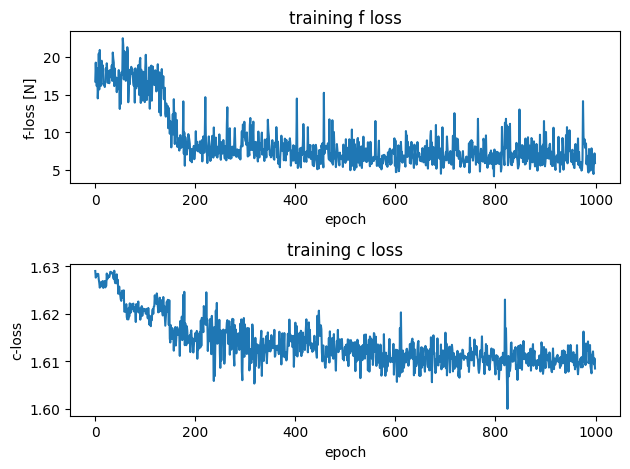

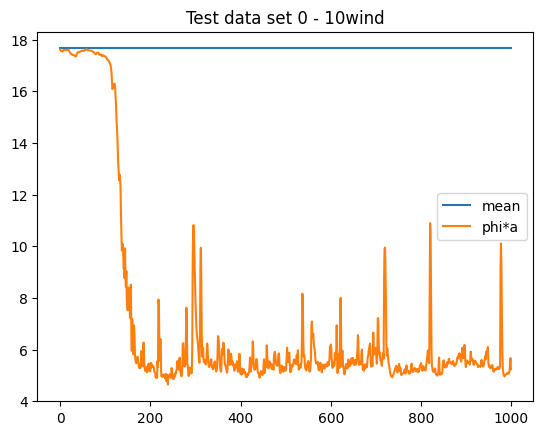

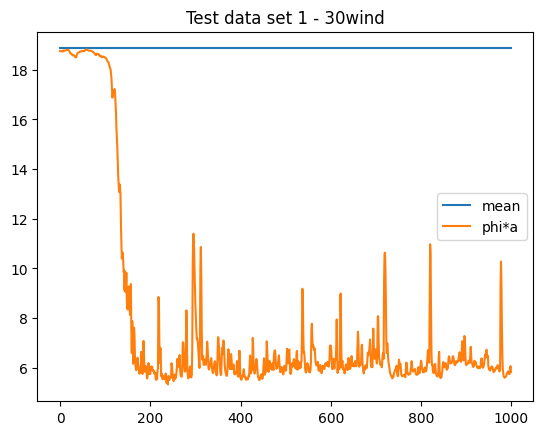

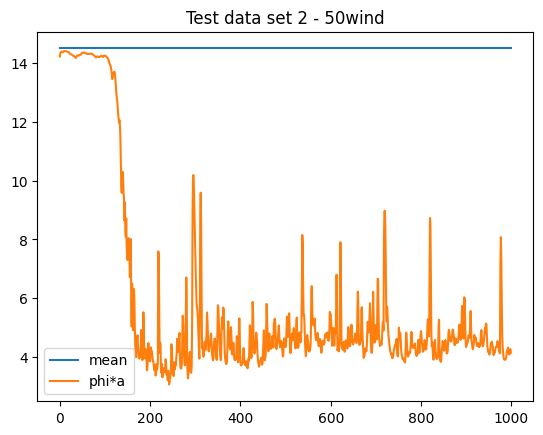

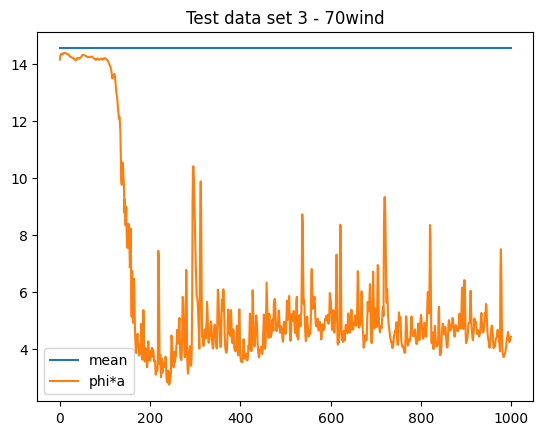

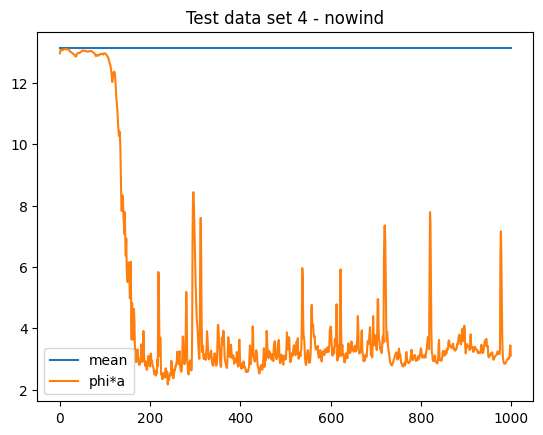

In [17]:
plt.subplot(2, 1, 1)
plt.plot(Loss_f)
plt.xlabel('epoch')
plt.ylabel('f-loss [N]')
plt.title('training f loss')
plt.subplot(2, 1, 2)
plt.plot(Loss_c)
plt.title('training c loss')
plt.xlabel('epoch')
plt.ylabel('c-loss')
plt.tight_layout()


# lxz:图的x轴是训练的次数，y轴是loss，表示随时间变化的训练过程中，不同风速环境下残差力预测的loss值
for j in range(len(TestData)):
    plt.figure()
    # plt.plot(Loss_test_nominal[j], label='nominal')
    plt.plot(Loss_test_mean[j], label='mean')
    plt.plot(np.array(Loss_test_phi[j]), label='phi*a')
    # plt.plot(np.array(Loss_test_exp_forgetting[j]), label='exp forgetting')
    plt.legend()
    plt.title(f'Test data set {j} - {TestData[j].meta["condition"]}')

plt.show()

In [18]:
# Choose final model
stopping_epoch = 200
options['num_epochs'] = stopping_epoch
final_model = mlmodel.load_model(modelname = modelname + '-epoch-' + str(stopping_epoch))

# Error Analysis

Plot the measured aerodynamic force, labeled ground truth (gt), along with the region used for adapation (adapt), and the predicted region (val)

------------------------------
10wind:
a = [[-5.31290721e-01  1.20427573e-15  7.51278323e+00]
 [-2.82889467e+00 -1.55037564e-15  6.06063781e+00]
 [ 1.55051884e-01 -1.88666631e-16  1.05589058e+00]]
|a| = 10.129022823398017


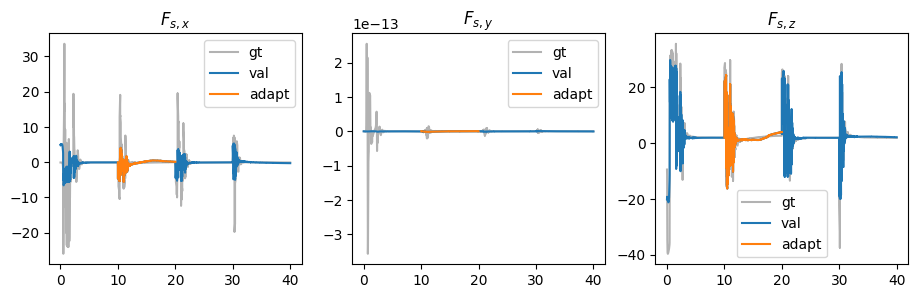

------------------------------
30wind:
a = [[-3.87121925e-01 -5.88572582e-18  7.80396442e+00]
 [-3.31179846e+00 -9.05006131e-17  5.65948464e+00]
 [-3.78659205e-01  3.18201669e-18  1.13578933e+00]]
|a| = 10.270486829354226


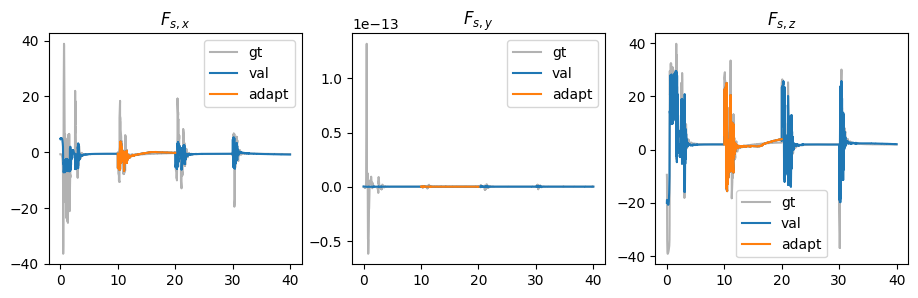

------------------------------
50wind:
a = [[ 9.39494473e-02 -4.84315659e-17  8.03868477e+00]
 [-3.40006946e+00 -4.40267617e-17  5.90333924e+00]
 [-1.43411816e+00  1.02796453e-17  1.16613372e+00]]
|a| = 10.698398409299024


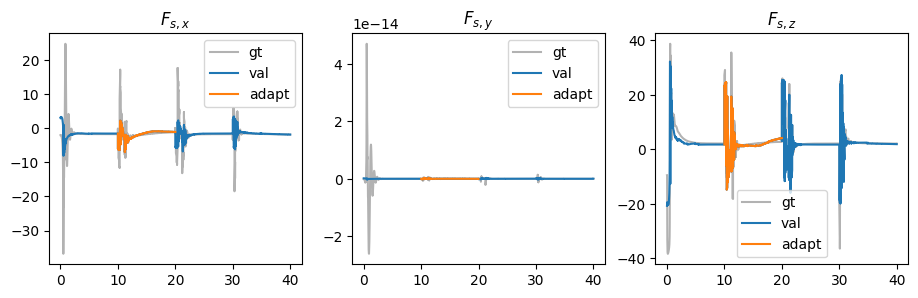

------------------------------
70wind:
a = [[ 4.80724768e-01  6.13799839e-17  7.66022361e+00]
 [-3.13135988e+00  3.98327459e-17  4.87718549e+00]
 [-2.96396849e+00 -4.61561581e-18  1.60692221e+00]]
|a| = 10.19165262787245


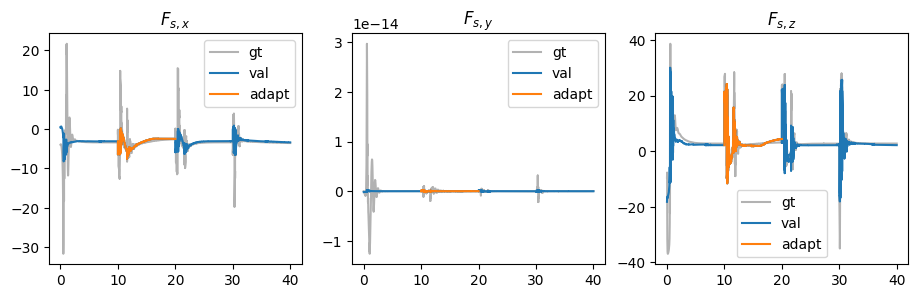

------------------------------
nowind:
a = [[-8.55631832e-01 -9.85909148e-17  7.39544098e+00]
 [-2.82535715e+00 -1.24870354e-16  5.77694160e+00]
 [ 2.89748006e-01  2.47704052e-17  1.07627684e+00]]
|a| = 9.900640185813003


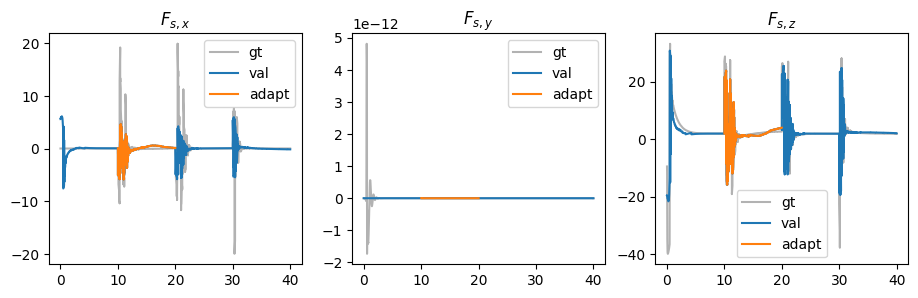

In [19]:
for i, data in enumerate(Data):  # lxz:使用测试数据进行测试
    print('------------------------------')
    print(data.meta['condition'] + ':')
    mlmodel.vis_validation(t=data.meta['t'], x=data.X, y=data.Y, phi_net=final_model.phi, h_net=final_model.h, idx_adapt_start=500, idx_adapt_end=1000, idx_val_start=0, idx_val_end=2000, c=Data[i].C, options=options)

In [20]:
for data in Data:
    error_1, error_2, error_3 = mlmodel.error_statistics(data.X, data.Y, final_model.phi, final_model.h, options=options)
    print('**** c =', str(data.C), ':', data.meta['condition'], '****')
    print(f'Before learning: MSE is {error_1: .2f}')
    print(f'Mean predictor: MSE is {error_2: .2f}')
    print(f'After learning phi(x): MSE is {error_3: .2f}')
    print('')

**** c = 0 : 10wind ****
Before learning: MSE is  19.96
Mean predictor: MSE is  18.22
After learning phi(x): MSE is  7.17

**** c = 1 : 30wind ****
Before learning: MSE is  21.50
Mean predictor: MSE is  19.54
After learning phi(x): MSE is  7.67

**** c = 2 : 50wind ****
Before learning: MSE is  17.50
Mean predictor: MSE is  14.65
After learning phi(x): MSE is  5.69

**** c = 3 : 70wind ****
Before learning: MSE is  20.27
Mean predictor: MSE is  13.57
After learning phi(x): MSE is  5.47

**** c = 4 : nowind ****
Before learning: MSE is  15.02
Mean predictor: MSE is  13.61
After learning phi(x): MSE is  4.73



## Test Data Error Analysis

------------------------------
10wind:
a = [[-8.91083379e-01  4.59576795e-17  6.05294494e+00]
 [ 1.64626981e+00 -1.13827948e-16  1.22357040e+01]
 [-3.62635328e-01  1.36366842e-16 -2.76308812e-01]]
|a| = 13.78632223035867


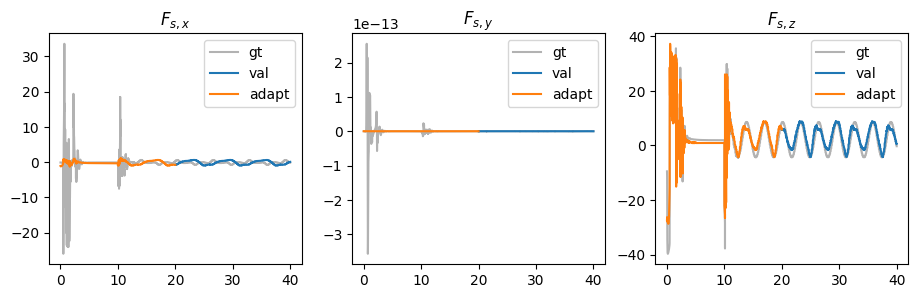

------------------------------
30wind:
a = [[-1.40135007e-02  5.19262940e-18  5.58255444e+00]
 [ 1.50646019e+00  2.87856332e-16  1.19955694e+01]
 [-1.06033184e+00 -9.52933965e-17 -4.12267031e-01]]
|a| = 13.364972302343633


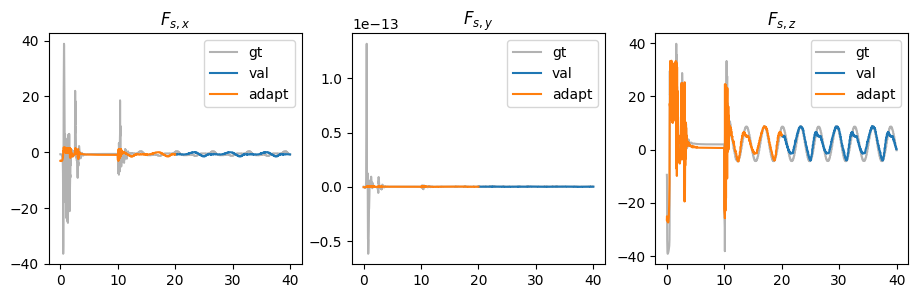

------------------------------
50wind:
a = [[ 1.28748399e+00  7.33706711e-16  7.55190484e+00]
 [-3.84328249e-01  3.78404442e-16  1.13382083e+01]
 [-1.82892431e+00 -8.35796786e-17  1.04885921e-01]]
|a| = 13.811137621437261


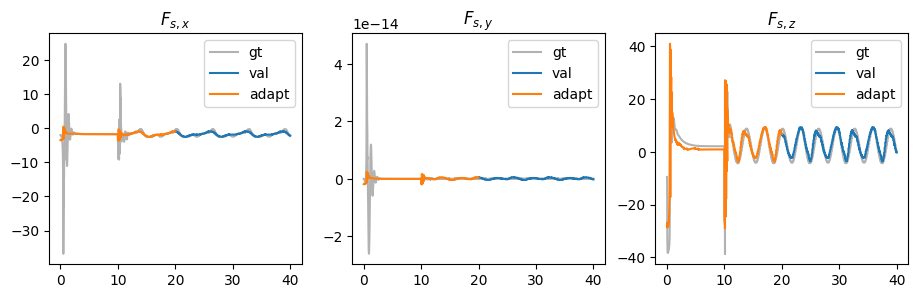

------------------------------
70wind:
a = [[ 2.36366938e+00  5.26799213e-16  7.70789304e+00]
 [-2.27209082e-01  2.02678304e-16  1.15954425e+01]
 [-3.50928367e+00 -4.57706977e-17  6.51466516e-01]]
|a| = 14.56859423855526


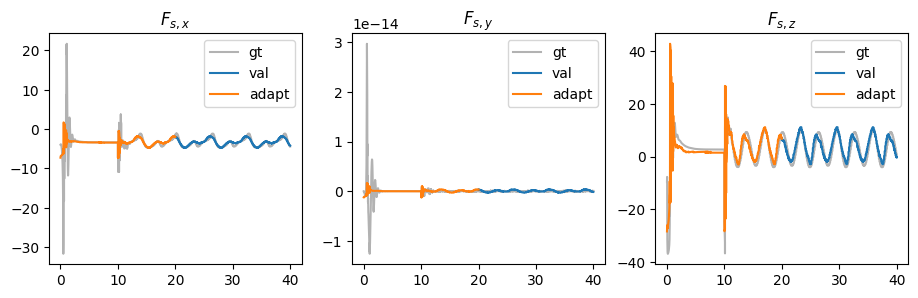

------------------------------
nowind:
a = [[ 1.84595726e-01  3.32489071e-14  6.39859411e+00]
 [ 3.92565174e-01  2.24502842e-14  1.14234961e+01]
 [-5.74060084e-02 -4.20672951e-15 -1.76895039e-01]]
|a| = 13.101947934668864


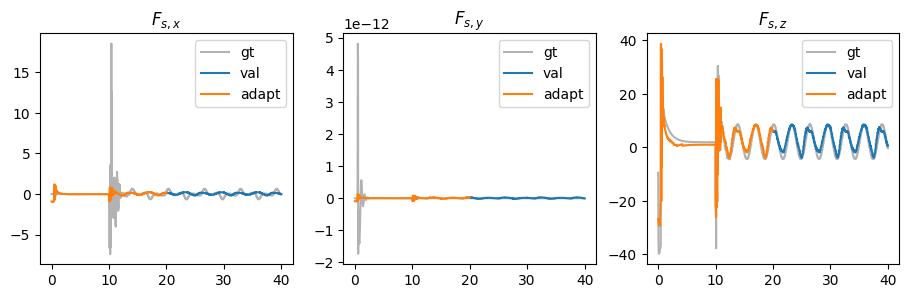

In [21]:
for i, data in enumerate(TestData):
    print('------------------------------')
    print(data.meta['condition'] + ':')
    mlmodel.vis_validation(t=data.meta['t'], x=data.X, y=data.Y, phi_net=final_model.phi, h_net=final_model.h, idx_adapt_start=0, idx_adapt_end=1000, idx_val_start=1000, idx_val_end=2000, c=Data[i].C, options=options)

In [22]:
for data in TestData:
    error_1, error_2, error_3 = mlmodel.error_statistics(data.X, data.Y, final_model.phi, final_model.h, options=options)
    print('**** :', data.meta['condition'], '****')
    print(f'Before learning: MSE is {error_1: .2f}')
    print(f'Mean predictor: MSE is {error_2: .2f}')
    print(f'After learning phi(x): MSE is {error_3: .2f}')
    print('')

**** : 10wind ****
Before learning: MSE is  19.33
Mean predictor: MSE is  17.65
After learning phi(x): MSE is  5.15

**** : 30wind ****
Before learning: MSE is  20.82
Mean predictor: MSE is  18.86
After learning phi(x): MSE is  5.76

**** : 50wind ****
Before learning: MSE is  17.30
Mean predictor: MSE is  14.50
After learning phi(x): MSE is  3.85

**** : 70wind ****
Before learning: MSE is  21.19
Mean predictor: MSE is  14.53
After learning phi(x): MSE is  3.59

**** : nowind ****
Before learning: MSE is  14.50
Mean predictor: MSE is  13.12
After learning phi(x): MSE is  2.75

